## Research Questions:

##### (a) How do Bechdel Test scores change over time? Are movies doing better at passing the Bechdel Test?

##### (b) How do different movie genres compare in terms of passing the Bechdel Test over the past decade?

##### (c) How do movie directors with the most films since the 00s compare in terms of passing the Bechdel Test?

##### (d) Has the correlation between passing the Bechdel Test and a movie's rating changed over the years?

### Steps:

1. Data Collection: Fetch data from the Bechdel Test API and load the Kaggle datasets.
2. Data Preparation: Clean datasets. Merge the datasets to create a unified structure. Maintain only relevant columns
3. Data Analysis: Answer the research questions based on the prepared data.

### **1. Data Collection**

#### Data Sources:

[Bechdel test API](https://www.bechdeltest.com):

[Kaggle movie details dataset](https://www.kaggle.com/datasets/rajugc/imdb-movies-dataset-based-on-genre)


##### Bechdel Test results using the bechdeltest.com API

In [ ]:
import requests
import pandas as pd
import numpy as np
import html
from scipy import stats
from google.colab import files

import matplotlib.pyplot as plt
%matplotlib inline
from plotnine import *
from skmisc.loess import loess
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
response = requests.get('http://bechdeltest.com/api/v1/getAllMovies')

movies_json = response.json()
df_bechdel = pd.DataFrame(movies_json)

##### IMDB dataset from Kaggle

In [ ]:
#imdb datasets per genre
imdb_genres = ['action', 'adventure', 'animation', 'biography', 'crime', 'family', 'fantasy', 'film-noir', 'history', 'horror', 'mystery', 'romance', 'scifi', 'sports', 'thriller', 'war']

#consolidate all csv
path = '/content/drive/MyDrive/DATA-PROJECTS_BIBI/1 - bechnel-analysis/movies-genres-datasets/'
df_imdb = pd.DataFrame()

for genre in imdb_genres:
  file = f"{path}{genre}.csv"
  df_temp = pd.read_csv(file)
  df_imdb = pd.concat([df_imdb, df_temp], ignore_index=True)

### **2. Data Preparation**

##### Bechdel Dataset

In [ ]:
#html decode text function
def decode_html(text):
    return html.unescape(text)

In [ ]:
# 1. decode text
df_bechdel['title'] = df_bechdel['title'].apply(decode_html)

# 2. reorder columns and rename
df_bechdel = df_bechdel.reindex(columns = ['title','rating','year', 'imdbid', 'id'])
df_bechdel.rename(columns={'rating': 'bechdel_rating', 'imdbid':'movie_id', 'id':'bechdel_id'}, inplace=True)

# 3. convert to object
df_bechdel['movie_id'] = df_bechdel['movie_id'].astype(str)

df_bechdel.head()

,title,bechdel_rating,year,movie_id,bechdel_id
0,Passage de Venus,0,1874,3155794,9602
1,La Rosace Magique,0,1877,14495706,9804
2,Sallie Gardner at a Gallop,0,1878,2221420,9603
3,Le singe musicien,0,1878,12592084,9806
4,Athlete Swinging a Pick,0,1881,7816420,9816


##### IMDB Dataset

In [ ]:
# 1. delete rows with repeated movies_ids
df_imdb = df_imdb.drop_duplicates(subset='movie_id')

# 2. remove 'tt' from movie_id
df_imdb['movie_id'] = df_imdb['movie_id'].str.replace('tt', '')

# 3. transform genres to a list
df_imdb['genre'] = df_imdb['genre'].str.split(',')

# 4. transform star to a list
df_imdb['star'] = df_imdb['star'].str.split(', \n')

# 5. drop irrelevant columns
df_imdb.drop(['certificate', 'runtime', 'description', 'director_id', 'star_id', 'votes', 'gross(in $)'], axis = 1, inplace = True)

# 6. rename columns
df_imdb.rename(columns={'rating': 'imdb_rating'}, inplace=True)

df_imdb.head()

,movie_id,movie_name,year,genre,imdb_rating,director,star
0,9114286,Black Panther: Wakanda Forever,2022,"[Action, Adventure, Drama]",6.9,Ryan Coogler,"[Letitia Wright, Lupita Nyong'o, Danai Gurira,..."
1,1630029,Avatar: The Way of Water,2022,"[Action, Adventure, Fantasy]",7.8,James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weave..."
2,5884796,Plane,2023,"[Action, Thriller]",6.5,Jean-François Richet,"[Gerard Butler, Mike Colter, Tony Goldwyn, Yos..."
3,6710474,Everything Everywhere All at Once,2022,"[Action, Adventure, Comedy]",8.0,"Dan Kwan, \nDaniel Scheinert","[Michelle Yeoh, Stephanie Hsu, Jamie Lee Curti..."
4,5433140,Fast X,2023,"[Action, Crime, Mystery]",NaN,Louis Leterrier,"[Vin Diesel, Jordana Brewster, Tyrese Gibson, ..."


In [ ]:
# 7. remove whitespaces in genre lists

def strip_whitespace(lst):
    if isinstance(lst, list):
        return [x.strip() for x in lst]
    return lst

df_imdb['genre'] = df_imdb['genre'].apply(strip_whitespace)


##### Merge the two datasets

In [ ]:
df = pd.merge(df_bechdel, df_imdb, on="movie_id")
df.head()

,title,bechdel_rating,year_x,movie_id,bechdel_id,movie_name,year_y,genre,imdb_rating,director,star
0,Miss Jerry,0,1894,0000009,9779,Miss Jerry,1894,[Romance],5.3,Alexander Black,"[Blanche Bayliss, William Courtenay, Chauncey ..."
1,"Story of the Kelly Gang, The",1,1906,0000574,1349,The Story of the Kelly Gang,1906,"[Action, Adventure, Biography]",6.0,Charles Tait,"[Elizabeth Tait, John Tait, Nicholas Brierley,..."
2,Cleopatra,2,1912,0002101,2003,Cleopatra,1912,"[Drama, History]",5.1,Charles L. Gaskill,"[Helen Gardner, Pearl Sindelar, Miss Fielding,..."
3,"Birth of a Nation, The",2,1915,0004972,1258,The Birth of a Nation,1915,"[Drama, War]",6.2,D.W. Griffith,"[Lillian Gish, Mae Marsh, Henry B. Walthall, M..."
4,Gretchen the Greenhorn,3,1916,0006745,2008,Gretchen the Greenhorn,1916,"[Crime, Drama, Romance]",6.4,"Chester M. Franklin, \nSidney Franklin","[Dorothy Gish, Ralph Lewis, Eugene Pallette, E..."


In [ ]:
#drop irrelevant columns
df.drop(['bechdel_id', 'movie_name', 'year_y'], axis = 1, inplace = True)

#rename year column
df.rename(columns={'year_x': 'year'}, inplace=True)

df.head()

,title,bechdel_rating,year,movie_id,genre,imdb_rating,director,star
0,Miss Jerry,0,1894,0000009,[Romance],5.3,Alexander Black,"[Blanche Bayliss, William Courtenay, Chauncey ..."
1,"Story of the Kelly Gang, The",1,1906,0000574,"[Action, Adventure, Biography]",6.0,Charles Tait,"[Elizabeth Tait, John Tait, Nicholas Brierley,..."
2,Cleopatra,2,1912,0002101,"[Drama, History]",5.1,Charles L. Gaskill,"[Helen Gardner, Pearl Sindelar, Miss Fielding,..."
3,"Birth of a Nation, The",2,1915,0004972,"[Drama, War]",6.2,D.W. Griffith,"[Lillian Gish, Mae Marsh, Henry B. Walthall, M..."
4,Gretchen the Greenhorn,3,1916,0006745,"[Crime, Drama, Romance]",6.4,"Chester M. Franklin, \nSidney Franklin","[Dorothy Gish, Ralph Lewis, Eugene Pallette, E..."


### **2. Data Analysis**

#### (a) How do Bechdel Test scores change over time? Are movies doing better at passing the Bechdel Test?

In [ ]:
#filter movies that passed the test
passed_test = df[df['bechdel_rating'] == 3]

#calculate the proportion of movies that passed the test by year
prop3_by_year = (
    passed_test.groupby('year')
    .size()
    .div(df.groupby('year').size())
    .reset_index(name='prop3')
)

#df with the total number of movies release per year
num_movies_by_year = df.groupby('year').size().reset_index(name='num_movies')

#Merge the prop3_by_year and num_movies_by_year DataFrames
combined_prop_by_year = pd.merge(prop3_by_year, num_movies_by_year, on='year')


/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


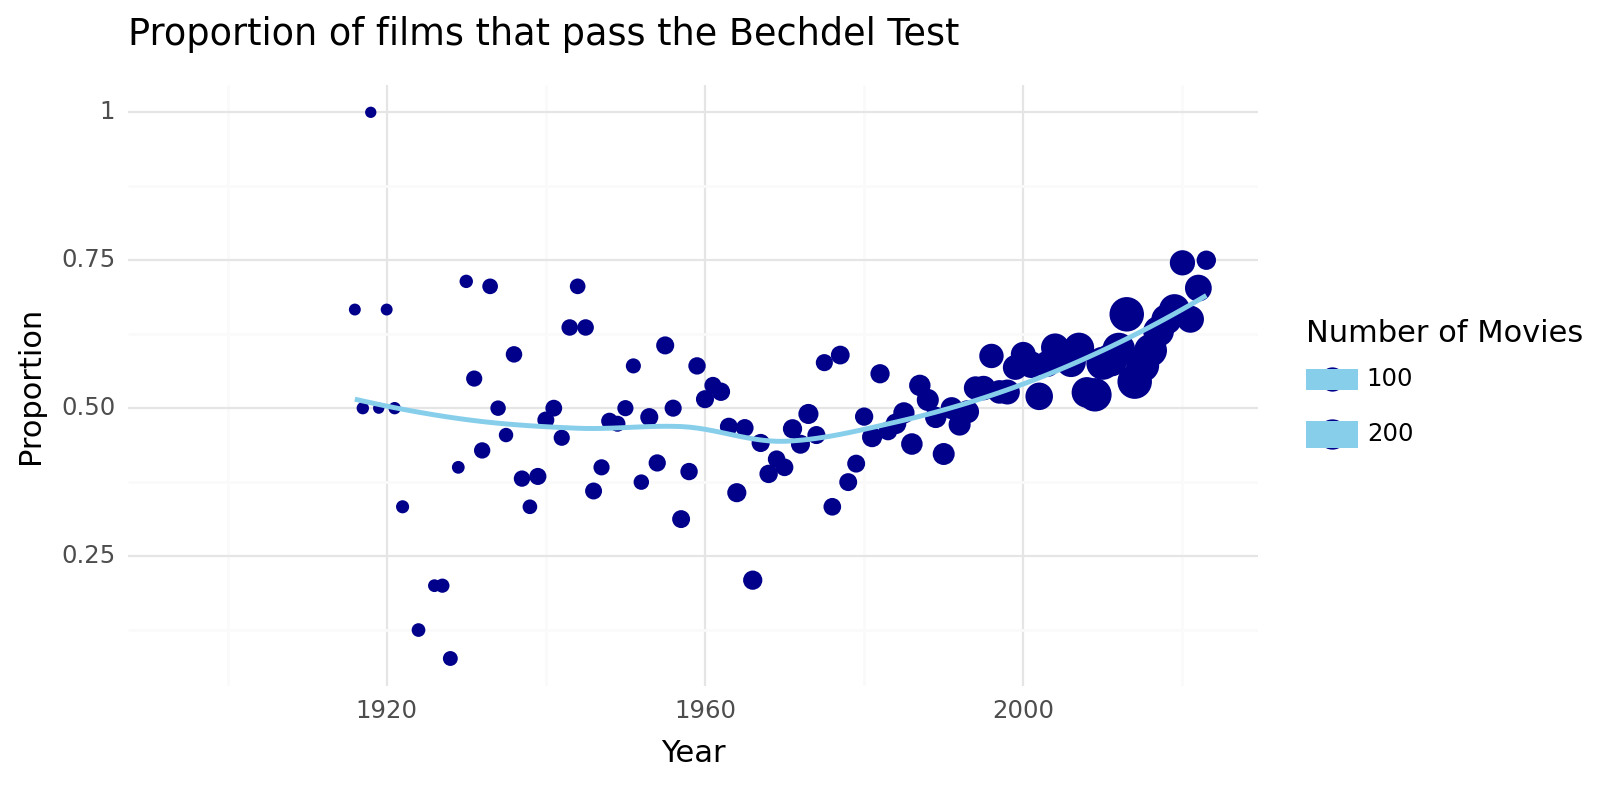

In [ ]:
#create the bubble chart
bubble_chart = (
    ggplot(combined_prop_by_year, aes(x='year', y='prop3', size='num_movies')) +
    geom_point(color="darkblue") +
    geom_smooth(color='skyblue', method='loess', se=False) +
    labs(
        title='Proportion of films that pass the Bechdel Test',
        x='Year',
        y='Proportion',
        size='Number of Movies'
    ) +
    theme_minimal() +
    theme(figure_size=(8, 4))
)

print(bubble_chart)

#### (b) How do different movie genres compare in terms of passing the Bechdel Test over the past decade?

In [ ]:
#filter movies from the last decade
last_decade_df = df[df['year'] >= 2013]

#explode the 'genre' column to convert lists to individual genre entries
last_decade_df_explode = last_decade_df.explode('genre')

#calculate bechdel_rating proportions per genre
genre_rating_proportions = (
    last_decade_df_explode.groupby(['genre', 'bechdel_rating'])
    .size()
    .unstack()
    .fillna(0)
    .div(last_decade_df_explode.groupby('genre').size(), axis=0)
)

#reorganize the columns in descending order
order = [3, 2, 1, 0]
genre_rating_proportions = genre_rating_proportions[order]

#calculate the mean proportion for movies with bechdel_rating = 3
mean_proportion_3 = genre_rating_proportions[3].mean()

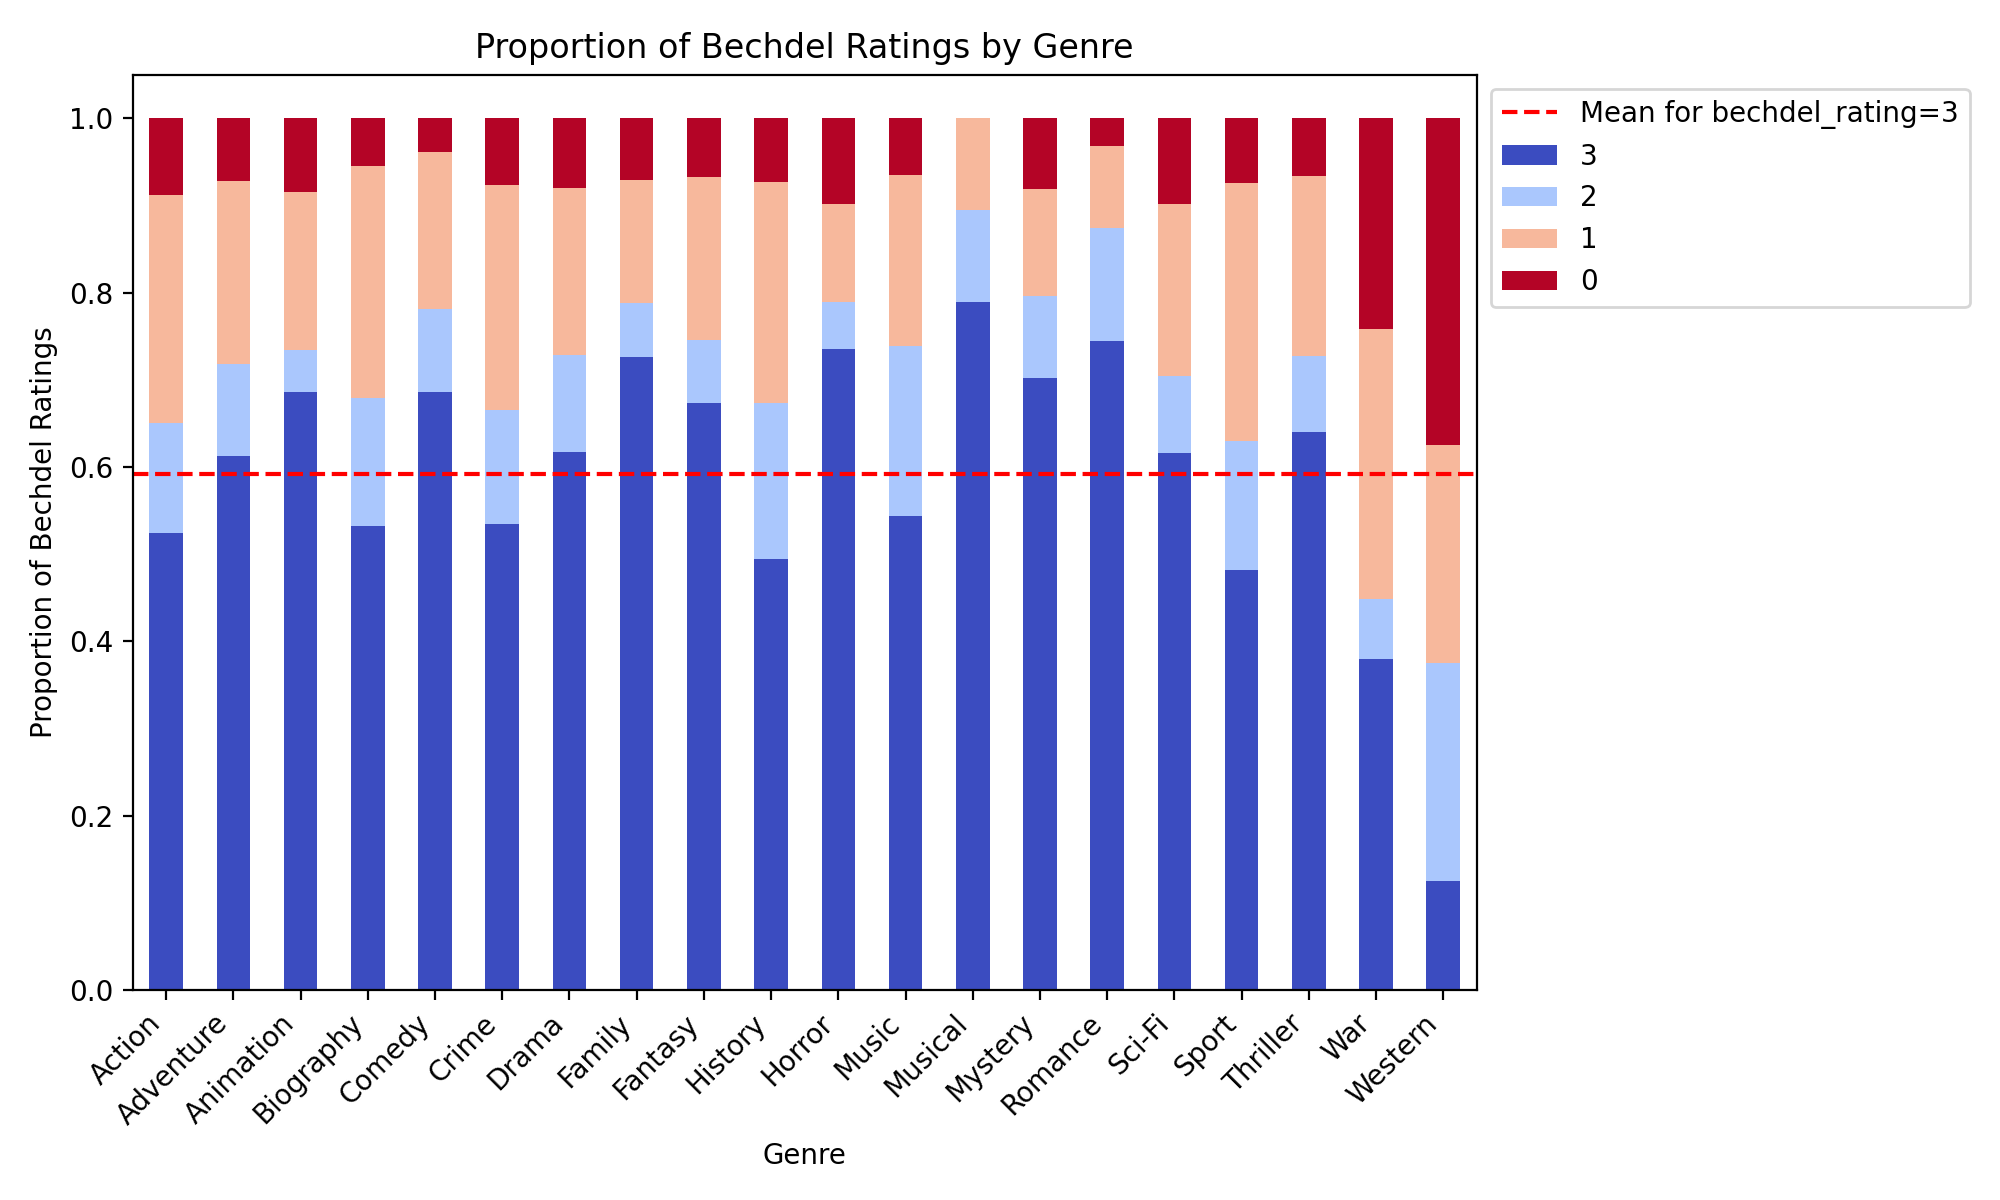

In [ ]:
#stacked bar chart
stack, ax = plt.subplots(figsize=(10, 6))

cmap = plt.get_cmap('coolwarm', len(order))
genre_rating_proportions.plot(kind='bar', stacked=True, ax=ax, colormap=cmap)
ax.axhline(y=mean_proportion_3, color='red', linestyle='--', label='Mean for bechdel_rating=3')
ax.set_ylabel('Proportion of Bechdel Ratings')
ax.set_xlabel('Genre')
ax.set_title('Proportion of Bechdel Ratings by Genre')

plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [ ]:
#genres with a lower than average ratio of 3
genres_below_mean = genre_rating_proportions.index[genre_rating_proportions[3] < mean_proportion_3].tolist()

print("Genres with a lower than average ratio of 3:")
print(genres_below_mean)

Genres with a lower than average ratio of 3:
['Action', 'Biography', 'Crime', 'History', 'Music', 'Sport', 'War', 'Western']


#### (c) How do movie directors with the most films over the past decade compare in terms of passing the Bechdel Test?

In [ ]:
#group las decade films by director
director_film_counts = last_decade_df.groupby('director')['movie_id'].count()

#get the top 25 directors with the highest film count
top_directors = director_film_counts.nlargest(25).index

#filter films by these directors
last_decade_df_by_top_directors = last_decade_df[last_decade_df['director'].isin(top_directors)]

#calculate the proportion of films that pass the Bechdel test (bechdel_rating == 3) for each director
director_bechdel_counts = last_decade_df_by_top_directors.groupby('director')['bechdel_rating'].count()
director_bechdel_passes = last_decade_df_by_top_directors[last_decade_df_by_top_directors['bechdel_rating'] == 3].groupby('director')['bechdel_rating'].count()
bechdel_proportion = director_bechdel_passes / director_bechdel_counts

#fill NaN values with 0
bechdel_proportion = bechdel_proportion.fillna(0)

bechdel_proportion_sorted = bechdel_proportion.sort_values(ascending=False)
##bechdel_proportion_sorted = bechdel_proportion.sort_index()
bechdel_proportion_sorted




director
Paul Feig                     1.000000
Mike Flanagan                 1.000000
James Wan                     0.833333
Jon M. Chu                    0.800000
Steven Spielberg              0.800000
Zack Snyder                   0.800000
Alexandre Aja                 0.750000
Craig Gillespie               0.750000
David Ayer                    0.750000
Andy Muschietti               0.750000
Kenneth Branagh               0.666667
Anthony Russo, \nJoe Russo    0.666667
Denis Villeneuve              0.666667
Steven Soderbergh             0.666667
Christopher Landon            0.600000
M. Night Shyamalan            0.600000
Ridley Scott                  0.571429
Bill Condon                   0.500000
Michael Bay                   0.333333
Christopher Nolan             0.250000
Bryan Singer                  0.250000
Robert Zemeckis               0.200000
Clint Eastwood                0.200000
Antoine Fuqua                 0.000000
Ron Howard                    0.000000
Name: bechdel_ra

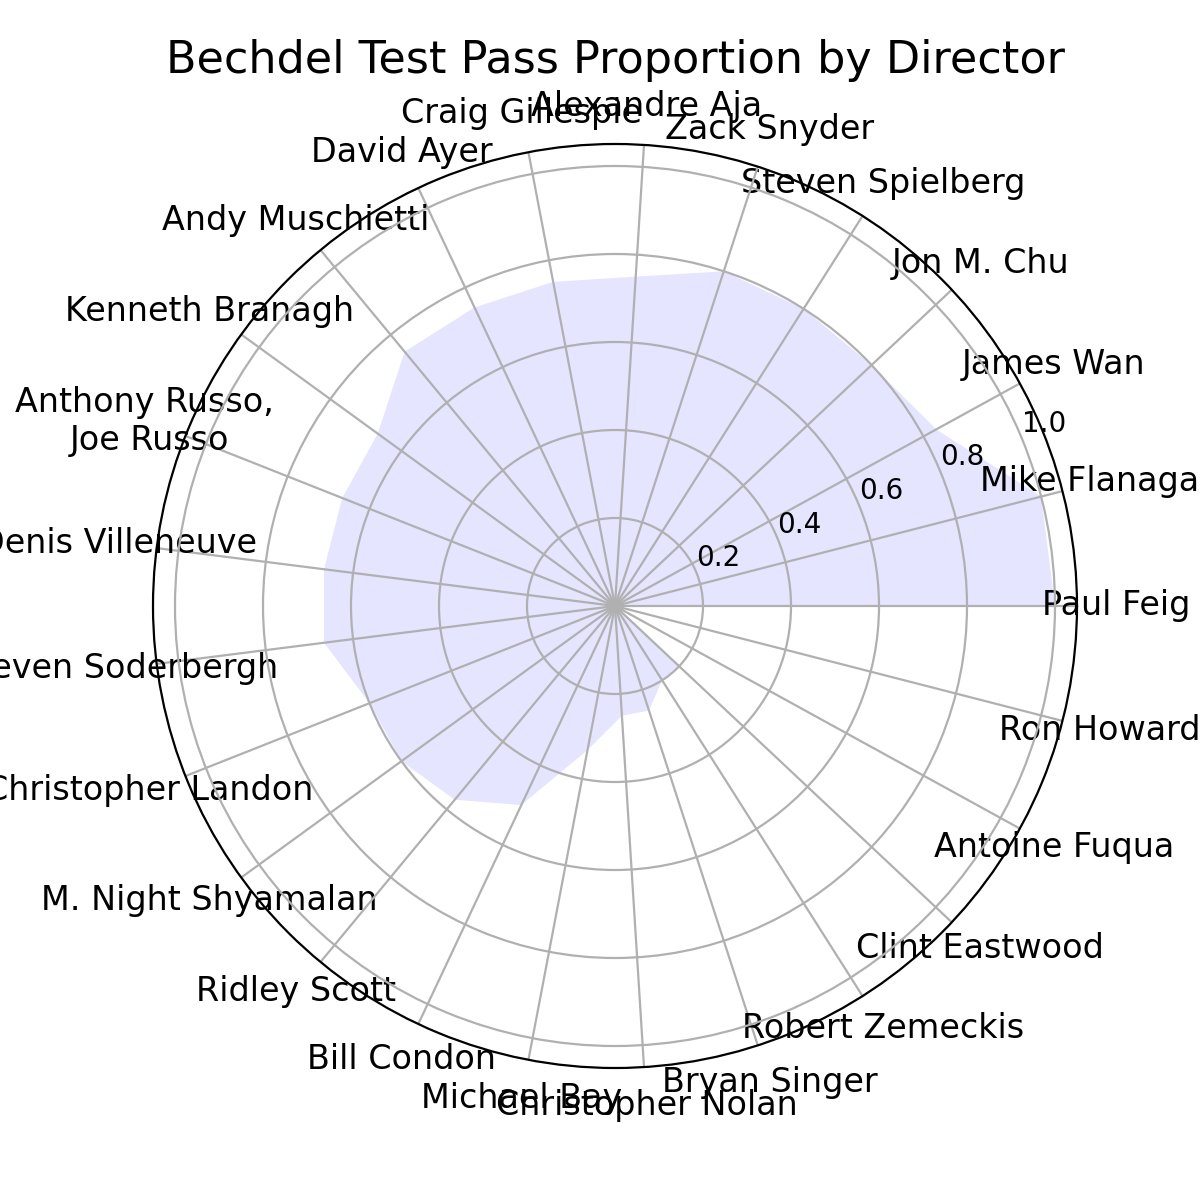

In [ ]:
#data
directors = bechdel_proportion_sorted.index
proportions = bechdel_proportion_sorted.values

#number of categories (directors)
categories = len(directors)

#create a list of evenly spaced angles for the radar chart
angles = np.linspace(0, 2 * np.pi, categories, endpoint=False).tolist()

#make the plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))

#close the plot
angles += angles[:1]
proportions = np.concatenate((proportions, [proportions[0]]))

#plot the data
ax.fill(angles, proportions, 'b', alpha=0.1)

#add labels for each category (director)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(directors, fontsize=12)

#add title and show the radar chart
plt.title('Bechdel Test Pass Proportion by Director', fontsize=16)
plt.show()

#### (d) Has the correlation between passing the Bechdel Test and a movie's rating changed over the years?

In [ ]:
#calculate Spearman's rank correlation coefficient
spearman_coef, spearman_p = stats.spearmanr(df_person_corr['bechdel_rating'], df_person_corr['imdb_rating'])

print(f"Spearman's rank correlation coefficient: {spearman_coef}")
print(f"P-value: {spearman_p}")


Spearman's rank correlation coefficient: -0.10468372210596187
P-value: 1.0075244778576068e-19
